In [2]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

     |████████████████████████████████| 735.5 MB 10 kB/s              B 69.2 MB/s eta 0:00:03| 633.6 MB 72.9 MB/s eta 0:00:02██████████████████████████████ | 712.3 MB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 54.7 MB/s            
     |████████████████████████████████| 15.3 MB 45.3 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires 

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset


%matplotlib inline

assert torch.__version__.startswith("1.8.0")
assert torchaudio.__version__ == "0.8.0"

device="cuda:0"

# Классификация аудиозаписей.

## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [4]:
# классы данных
classes = ['blues',
           'classical',
           'country',
           'disco',
           'hiphop',
           'jazz',
           'metal',
           'pop',
           'reggae',
           'rock']

In [5]:
class AudioDataset(Dataset):
    def __init__(
        self, 
        path_to_csv: str, 
        path_to_folder: str, 
        pad_size: int = 384000,
        sr: int = 44100 # sample rate
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)["filename"]
            
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
      # Напишите AudioDataset класс, который будет принимать путь к файлам
      # train_part.csv и val_part.csv и возращать тройки
      # объектов (x, y, len), где x - аудиозапись, y - класс
      # аудиозаписи, len - длина аудиозаписи. Аудиозаписи не должны постоянно
      # храниться в RAM, подгрузку wav файлов надо сделать при запросе
      # через __getitem__ метод. Кроме того, надо сделать паддинг аудиозаписи 
      # - если она короче чем pad_size параметр, надо дополнять ее нулями.
        ### YOUR CODE IS HERE ######

        id, wav_class = self.csv.iloc[index]

        path_to_wav = os.path.join(self.path_to_folder, f'{id}.wav')

        wav, sr = torchaudio.load(path_to_wav)
        wav = torch.flatten(wav)
        length = len(wav)
        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        if len(wav) < self.pad_size:
          wav = torch.cat((wav, torch.zeros(self.pad_size - len(wav))))
        wav = wav.squeeze()

        return {'x' : wav,
                'y' : self.class_to_idx[wav_class],
                'len': length}
        ### THE END OF YOUR CODE ###
        
    def __len__(self):
        return self.csv.shape[0]

In [6]:
# создадим датасеты
train_dataset = AudioDataset("/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv",
                             "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original")
# val_dataset = AudioDataset("../input/hw2iad/urbansound8k/val_part.csv", "../input/hw2iad/urbansound8k/data")

KeyError: "None of [Index(['ID', 'Class'], dtype='object')] are in the [columns]"

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000, )
assert item["y"] == 0
assert item["len"] == 176400

In [ ]:
t = torch.tensor([[1, 2],
                    [3, 4]])
t.flatten().size()

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    pin_memory=True, 
    drop_last=True,
    num_workers=2
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=32,
    pin_memory=True,
    num_workers=2
)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](https://github.com/hse-ds/iad-applied-ds/blob/master/2022/hw/hw2/imgs/rnn_raw.png?raw=1)

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        ### YOUR CODE IS HERE ######
        self.first_mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(1497, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(1497, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
        )

        self.rnn = nn.LSTM(input_size=16,
                           hidden_size=hidden,
                           num_layers=2,
                           bidirectional=True,
                           batch_first=True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * 2 * hidden, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.ReLU(),
            nn.LogSoftmax(),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens) -> torch.Tensor:
        # разбейте сигнал на окна 
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        batch_windows = x.unfold(-1, self.window_length, self.hop_length)


        # примените к каждому окну полносвязную сеть
        # batch_windows_features.shape == (B, NUM WINDOWS, 16)
        batch_windows_features = self.first_mlp(batch_windows)

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        output, (hidden_states, cell_state) = self.rnn(batch_windows_features)

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.flatten(torch.reshape(
            hidden_states, (hidden_states.size(1), hidden_states.size(0), 
                            hidden_states.size(2))), start_dim=1, end_dim=2)

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)

Обучим получившуюся модель.

In [ ]:
def train_audio_clfr(
    model, 
    optimizer, 
    train_dataloader, 
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None, 
    augmentation=None,
    num_epochs=1, device='cuda:0',
    verbose_num_iters=10
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):  
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs], 
            [p[0] for p in pred_true_pairs], 
            normalize="true"
        ),
        columns=classes, 
        index=classes
    )
    sn.heatmap(cm_df, annot=True)

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?
в целом, они похожи!

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [ ]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(
    wav_batch, 
    lens,
    sr,
    device="cpu"
):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
        ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [ ]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
windows = batch["x"].unfold(-1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)
fft_magnitudes = torch.abs(fft_features ** 2)[:, :, :n_fft // 2 + 1]
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale =  torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1).to(device)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.cpu().numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [ ]:
mel_spectrogram = melscale(torch.transpose(fft_magnitudes, -1, -2).to(device)).to(device)
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)).to(device)
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].cpu().numpy())

Теперь оформим эту логику в функцию.

In [ ]:
# ваша реализация
def compute_log_melspectrogram(
    wav_batch,
    lens,
    sr,
    device="cpu"
):
  ### YOUR CODE IS HERE ######
  windows = wav_batch.unfold(-1, win_length, hop_length).to(device)
  filter = torch.hann_window(win_length).to(device)
  windows_with_applied_filter = windows * filter[None, None, :].to(device)
  fft_features = torch.fft.fft(windows_with_applied_filter).to(device)
  fft_magnitudes = torch.abs(fft_features ** 2)[:, :, :n_fft // 2 + 1].to(device)
  melscale =  torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1).to(device)
  mel_spectrogram = melscale(torch.transpose(fft_magnitudes, -1, -2)).to(device)
  logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)).to(device)
  return logmel_spectrogram, lens // 256
  ### THE END OF YOUR CODE ###

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5
)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](https://github.com/hse-ds/iad-applied-ds/blob/master/2022/hw/hw2/imgs/rnn_mel.png?raw=1)

**За реализацию архитектуры дается 0.5 балла.**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        ### YOUR CODE IS HERE ######
        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=hidden,
                           num_layers=2,
                           bidirectional=True,
                           batch_first=True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * 2 * hidden, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.ReLU(),
            nn.LogSoftmax(),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens):
        ### YOUR CODE IS HERE ###### 
        # примените к получившемся последовательностям LSTM и возьмите hidden state
        output, (hidden_states, cell_state) = self.rnn(torch.transpose(x, -1, -2))

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.flatten(torch.reshape(
            hidden_states, (hidden_states.size(1), hidden_states.size(0), 
                            hidden_states.size(2))), start_dim=1, end_dim=2)

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)
        ### THE END OF YOUR CODE ###

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

In [ ]:
%%time
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram, num_epochs=10)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

In [ ]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        ### YOUR CODE IS HERE ######
#         Реализуем такую сверточную сеть:

# (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
# (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
# Global MaxPoll
# Fully Connected 128, ReLU
# Fully Connected 10
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.final_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [ ]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

In [ ]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=10)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [ ]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = "mean",
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        ### YOUR CODE IS HERE ######
        
        ### THE END OF YOUR CODE ###

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [ ]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

# 2 вариант

https://music-classification.github.io/tutorial/part3_supervised/tutorial.html

In [2]:
!pip install torchaudio_augmentations

     |████████████████████████████████| 59 kB 6.5 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21895 sha256=69b4465e70424c54a4ae4135ee4ce3934b11a796775f0bffb6aebc3ca832d786
  Stored in directory: /root/.cache/pip/wheels/44/52/2c/7dd069f82c7f905f40b190a8039ec2a17fdd4bb009c57c6664
Successfully built julius


In [3]:
import os
import random
import torch
import numpy as np
import soundfile as sf
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   num_samples=22050 * 29, 
                   num_chunks=1, 
                   batch_size=16, 
                   num_workers=0, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader


RuntimeError: torchaudio.sox_effects.sox_effects.effect_names requires sox

In [8]:
df = pd.DataFrame(names_weights_height.values())

In [9]:
df

,0,1
0,184,83
1,182,78
2,188,78
3,191,87
4,192,88
5,186,80
6,187,71
7,177,70


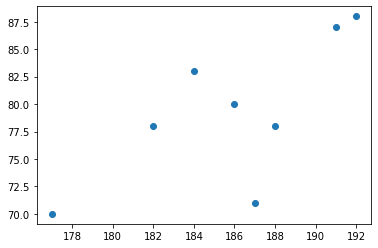

In [16]:
plt.scatter(df[0], df[1])

<AxesSubplot:>

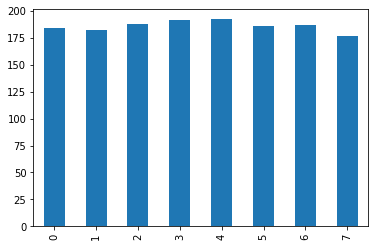

In [19]:
df[0].plot(kind='bar')

<AxesSubplot:>

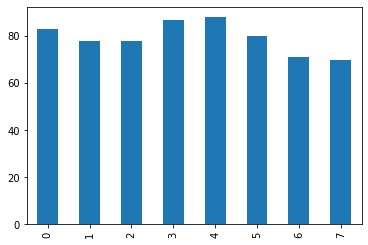

In [20]:
df[1].plot(kind='bar')